In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.decomposition import PCA
from scipy.stats import zscore

In [2]:
df = pd.read_csv("..\\data\\exoplanet_dataset.csv")  


In [3]:
display(df.head())
display(df.info())

,P_NAME,P_DETECTION,P_DISCOVERY_FACILITY,P_YEAR,P_UPDATE,P_MASS,P_MASS_ORIGIN,P_RADIUS,P_PERIOD,P_SEMI_MAJOR_AXIS,...,S_SNOW_LINE,S_ABIO_ZONE,S_TIDAL_LOCK,P_HABZONE_OPT,P_HABZONE_CON,P_TYPE_TEMP,P_HABITABLE,S_CONSTELLATION,S_CONSTELLATION_ABR,S_CONSTELLATION_ENG
0,OGLE-2016-BLG-1227L b,Microlensing,OGLE,2020,2020-04-02,250.00,Mass,13.90,NaN,3.4000,...,NaN,NaN,0.214133,0,0,NaN,0,Scorpius,Sco,Scorpion
1,Kepler-276 c,Transit,Kepler,2013,2018-09-25,16.60,Mass,2.90,31.884000,0.1994,...,2.437046,2.097783,0.316980,0,0,Hot,0,Cygnus,Cyg,Swan
2,Kepler-829 b,Transit,Kepler,2016,2019-04-16,5.10,M-R relationship,2.11,6.883376,0.0678,...,2.827247,1.756317,0.459559,0,0,Hot,0,Lyra,Lyr,Lyre
3,K2-283 b,Transit,K2,2018,2019-09-05,12.20,M-R relationship,3.52,1.921036,0.0291,...,1.476943,0.568374,0.443760,0,0,Hot,0,Pisces,Psc,Fishes
4,Kepler-477 b,Transit,Kepler,2016,2019-04-16,4.94,M-R relationship,2.07,11.119907,0.0911,...,1.759397,0.768502,0.386150,0,0,Hot,0,Lyra,Lyr,Lyre


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5599 entries, 0 to 5598
Data columns (total 57 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   P_NAME                5599 non-null   object 
 1   P_DETECTION           5599 non-null   object 
 2   P_DISCOVERY_FACILITY  5599 non-null   object 
 3   P_YEAR                5599 non-null   int64  
 4   P_UPDATE              5599 non-null   object 
 5   P_MASS                5592 non-null   float64
 6   P_MASS_ORIGIN         5599 non-null   object 
 7   P_RADIUS              5592 non-null   float64
 8   P_PERIOD              5350 non-null   float64
 9   P_SEMI_MAJOR_AXIS     5595 non-null   float64
 10  P_ECCENTRICITY        4822 non-null   float64
 11  P_INCLINATION         4288 non-null   float64
 12  P_OMEGA               1659 non-null   float64
 13  S_NAME                5599 non-null   object 
 14  S_NAME_HD             971 non-null    object 
 15  S_NAME_HIP           

None

In [4]:
imputer = KNNImputer(n_neighbors=5)
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_cols] = imputer.fit_transform(df[numeric_cols])


In [5]:
categorical_cols = df.select_dtypes(include=['object']).columns
encoder = LabelEncoder()
for col in categorical_cols:
    df[col] = encoder.fit_transform(df[col])

In [6]:
def remove_outliers(df, threshold=3):
    z_scores = np.abs(zscore(df[numeric_cols]))
    return df[(z_scores < threshold).all(axis=1)]
df = remove_outliers(df)

In [7]:
Re, Te = 1, 288
df['ESI'] = np.sqrt((1 - abs(df['P_RADIUS'] - Re) / (df['P_RADIUS'] + Re)) * 
                     (1 - abs(df['P_TEMP_EQUIL'] - Te) / (df['P_TEMP_EQUIL'] + Te)))

In [8]:
df['Gravitational_Retention'] = df['P_ESCAPE'] / df['P_GRAVITY']
def habitability_score(row):
    return 0.4 * row['ESI'] + 0.3 * row['P_HABZONE_OPT'] + 0.3 * row['P_HABZONE_CON']
df['Habitability_Score'] = df.apply(habitability_score, axis=1)

In [9]:
scaler = MinMaxScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

In [10]:
pca = PCA(n_components=0.95) 
df_pca = pca.fit_transform(df[numeric_cols])



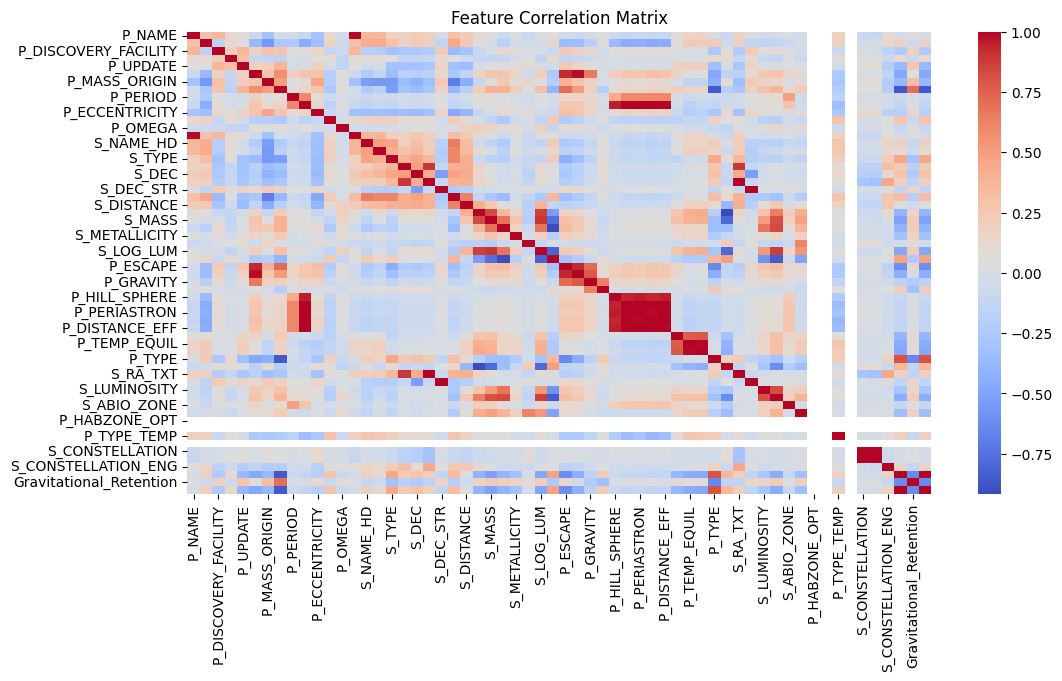

In [11]:

plt.figure(figsize=(12, 6))
sns.heatmap(df.corr(), cmap='coolwarm', annot=False)
plt.title('Feature Correlation Matrix')
plt.show()


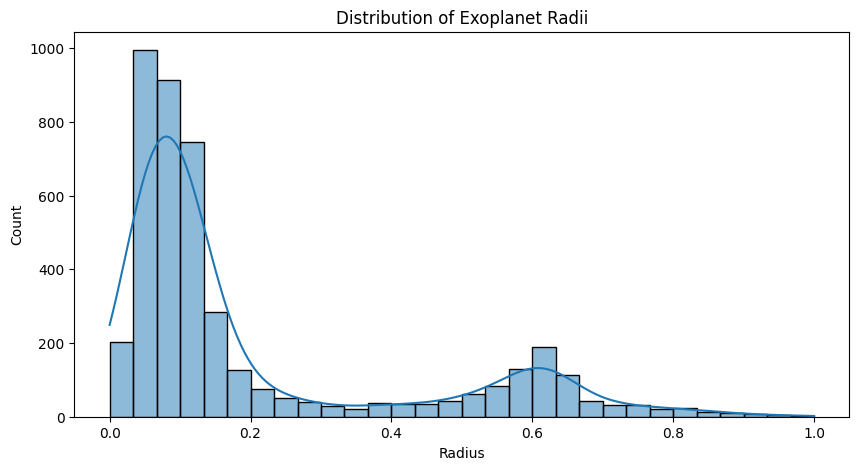

In [12]:
plt.figure(figsize=(10, 5))
sns.histplot(df['P_RADIUS'], bins=30, kde=True)
plt.title('Distribution of Exoplanet Radii')
plt.xlabel('Radius')
plt.ylabel('Count')
plt.show()

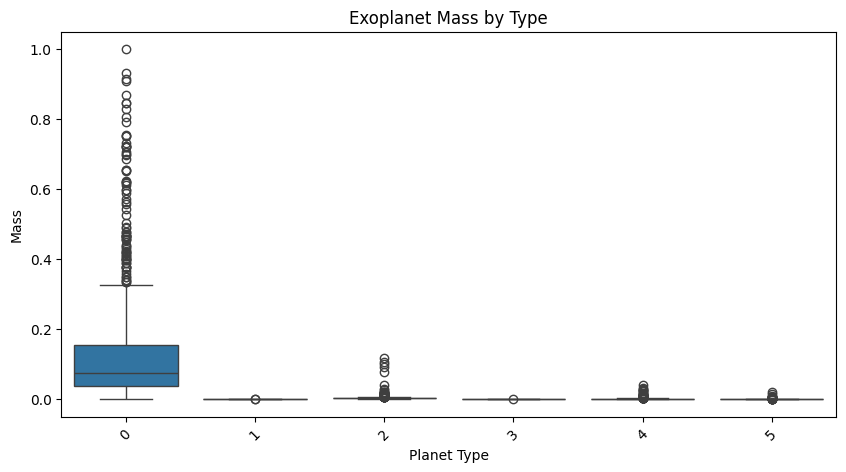

In [13]:

plt.figure(figsize=(10, 5))
sns.boxplot(x=df['P_TYPE'], y=df['P_MASS'])
plt.title('Exoplanet Mass by Type')
plt.xlabel('Planet Type')
plt.ylabel('Mass')
plt.xticks(rotation=45)
plt.show()

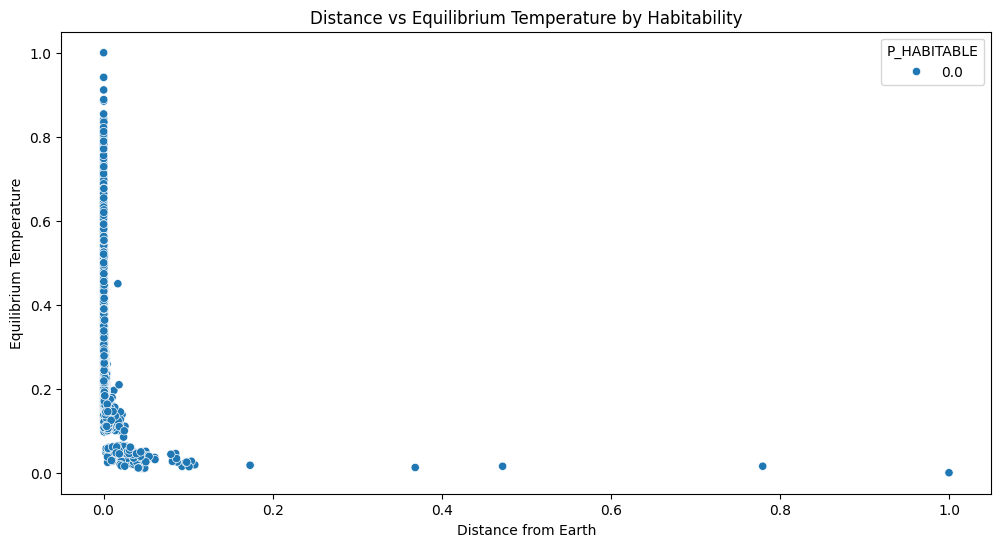

In [14]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x=df['P_DISTANCE'], y=df['P_TEMP_EQUIL'], hue=df['P_HABITABLE'])
plt.title('Distance vs Equilibrium Temperature by Habitability')
plt.xlabel('Distance from Earth')
plt.ylabel('Equilibrium Temperature')
plt.show()

In [15]:
df.to_csv("preprocessed_exoplanet_data.csv", index=False)